In [2]:
# compare collaborative filtering recommender model with popularity based recommender model
# Amazon Fine Food Review dataset

import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import os

In [5]:
data = pd.read_csv("/Users/vb/Desktop/dataset/foodreview/Reviews.csv")

In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
data = data.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary'], axis = 1) 

In [12]:
rows, columns = data.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  568454
No of columns:  3


In [13]:
data.dtypes

ProductId    object
UserId       object
Score         int64
dtype: object

In [18]:
print('Missing values across columns:\n', data.isnull().sum())

Missing values across columns:
 ProductId    0
UserId       0
Score        0
dtype: int64


In [19]:
# summary stats of rating
data[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [20]:
# min and max ratings

def min_max_rating():
    print('Minimum rating: %d' %(df['Score'].min()))
    print('Maximum rating: %d' %(df['Score'].max()))
    
min_max_rating()


Minimum rating: 1
Maximum rating: 5


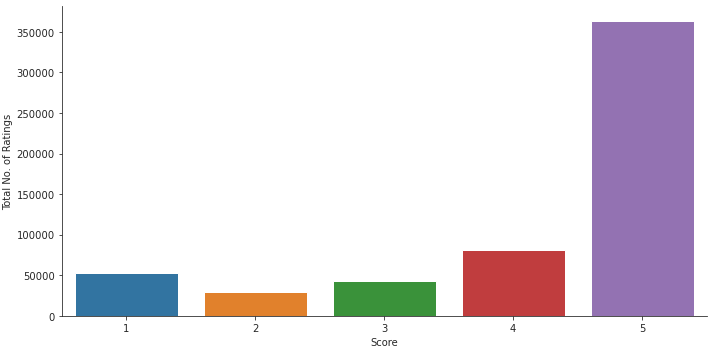

In [23]:
# Distribution of ratings

with sns.axes_style('ticks'):
    p1 = sns.factorplot("Score", data=df, aspect=2.0, kind='count')
    p1.set_ylabels("Total No. of Ratings")

In [24]:
# users who give over 50 ratings
highest = df.groupby('UserId').size().sort_values(ascending=False)[:10] #10 users
highest

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
dtype: int64

In [26]:
count = df['UserId'].value_counts()
finaldata = df[df['UserId'].isin(count[count >= 50].index)]

In [27]:
finaldata.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,1209686400,Great taste and convenience,We really like the McCann's steel cut oats but...
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,1192752000,good,Good oatmeal. I like the apple cinnamon the b...
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,1316390400,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,1301788800,Good Licorice,Twizzlers brand licorice is much better than t...


In [30]:
print("No. of users rating over 50 items =", len(finaldata))
print("No. of unique users in data =", finaldata['UserId'].nunique())
print("No. of unique items in data =", finaldata['ProductId'].nunique())

No. of users rating over 50 items = 22941
No. of unique users in data = 267
No. of unique items in data = 11313


In [32]:
# density of rating matrix
ratingsmatrix_final = pd.pivot_table(finaldata,index=['UserId'], columns = 'ProductId', values = "Score")
ratingsmatrix_final.fillna(0,inplace=True)
print('ratingsmatrix_final shape: ', ratingsmatrix_final.shape)
ratingsgiven = np.count_nonzero(ratingsmatrix_final)
print('ratingsgiven shape = ', ratingsgiven)
possible_ratings = ratingsmatrix_final.shape[0] * ratingsmatrix_final.shape[1]
print('possible ratings = ', possible_ratings)
density = (ratingsgiven/possible_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

ratingsmatrix_final shape:  (267, 11313)
ratingsgiven shape =  20829
possible ratings =  3020571
density: 0.69%


In [35]:
ratingsfinalT = ratingsmatrix_final.transpose()
ratingsfinalT.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [104]:
#split data into 70/30

train_data, test_data = train_test_split(finaldata, test_size = 0.3, random_state=0)
print(train_data.head(10))

            Id   ProductId          UserId  \
399863  399864  B002IEVJRY  A1N5FSCYN4796F   
20262    20263  B001BDDTB2  A1Q7A78VSQ5GQ4   
139611  139612  B001BCXTGS  A2PNOU7NXB1JE4   
455504  455505  B005HG9ERW  A2SZLNSI5KOQJT   
512008  512009  B0028PDER6   ALSAOZ1V546VT   
319294  319295  B000OU5EFW  A3EBHHCZO6V2A4   
436889  436890  B007KIOBMS  A2YHXAZLCLDT8D   
355293  355294  B0018RYBZE  A17GK9E70O7Y9R   
286702  286703  B001BUCXXA  A13WOT3RSXKRD5   
301888  301889  B000EMOCRQ  A1Z54EM24Y40LL   

                                        ProfileName  HelpfulnessNumerator  \
399863    Philip R. Heath "Gadgets, Music, & Books"                     0   
20262               Nice Lady "a reasonable person"                     0   
139611                               Peggy "pab920"                     0   
455504   Carrie, "Formerly &#34;Sister Carrie&#34;"                     1   
512008  A Research It Maven "Just the facts please"                     2   
319294                         

In [38]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape() 

Test data shape:  (6883, 10)
Train data shape:  (16058, 10)


In [47]:
# non personalized recommendation model based on popularity

#User id count for unique product as score
grouped_train_data= train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
grouped_train_data.rename(columns = {'UserId': 'score'},inplace=True)
grouped_train_data.head()

,ProductId,score
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [53]:
# products sorted based on score
sort_train_data = grouped_train_data.sort_values(['score', 'ProductId'], ascending = [0,1]) 

# recommendation: ranking based on score
sort_train_data['Rank'] = sort_train_data['score'].rank(ascending=0, method='first')                                                   
                                                  
# top 5
popularfive_rec = sort_train_data.head(5) 
popularfive_rec

,ProductId,score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
6779,B0041NYV8E,39,4.0
7876,B005HG9ET0,39,5.0


In [64]:
# popular recommendation model for making predictions:
def recommender(user_id):     
    user_rec = popularfive_rec
    user_rec['UserId'] = user_id 

In [68]:
find_recom = [22,80,213]
for i in find_recom:
    print("Recommendation for userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Recommendation for userId: 22

      UserId   ProductId  score  Rank
5621      22  B002IEZJMA     48   1.0
8130      22  B006MONQMC     42   2.0
5620      22  B002IEVJRY     41   3.0
6779      22  B0041NYV8E     39   4.0
7876      22  B005HG9ET0     39   5.0


Recommendation for userId: 80

      UserId   ProductId  score  Rank
5621      80  B002IEZJMA     48   1.0
8130      80  B006MONQMC     42   2.0
5620      80  B002IEVJRY     41   3.0
6779      80  B0041NYV8E     39   4.0
7876      80  B005HG9ET0     39   5.0


Recommendation for userId: 213

      UserId   ProductId  score  Rank
5621     213  B002IEZJMA     48   1.0
8130     213  B006MONQMC     42   2.0
5620     213  B002IEVJRY     41   3.0
6779     213  B0041NYV8E     39   4.0
7876     213  B005HG9ET0     39   5.0




In [69]:
# same recommendations for all users (popularity based)

In [70]:
# CF model
dataCF = pd.concat([train_data, test_data]).reset_index()
dataCF.tail()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22936,275741,275742,B001M23WVY,AY1EF0GOH80EK,Natasha Stryker,0,0,2,1350950400,"Taste like metal, 4 of 6 cans badly dented",I was not happy with these art heart bottoms. ...
22937,281102,281103,B002R8SLUY,A16AXQ11SZA8SQ,"MamaBear007 ""MamaBear007""",6,6,5,1268179200,My dogs dance for these treats!,A dear friend sent these to my dogs as a gift....
22938,205589,205590,B00473PVVO,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",0,0,5,1320451200,Coconut Custard Pie,If you still have the June 2011 issue of Famil...
22939,303238,303239,B0002DGRZC,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
22940,36703,36704,B000EEWZD2,A2M9D9BDHONV3Y,A. Bennett,1,1,3,1206230400,Tasty but overcooked!,I like to make a quick salad using these tiny ...


In [71]:
# user-based CF model
new_df = pd.pivot_table(dataCF,index=['UserId'], columns = 'ProductId', values = "Score")
new_df.fillna(0,inplace=True)
print(new_df.shape)
new_df.head()

(267, 11313)


ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
new_df['user_index'] = np.arange(0, new_df.shape[0], 1)
new_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [74]:
new_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
new_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Large sparse matrix: SVD

from scipy.sparse.linalg import svds
# SVD
U, sigma, Vt = svds(new_df, k=50)
# Diagonal array in SVD
sigma = np.diag(sigma)

In [79]:
pred_ratings_users = np.dot(np.dot(U, sigma), Vt)

# predicted ratings
pred_df = pd.DataFrame(pred_ratings_users, columns = new_df.columns)
pred_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,...,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,...,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,...,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,...,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392,0.008952,0.008952,-0.000043,0.012956,0.008952,-0.007402,0.004274,...,0.014244,0.014244,0.011886,0.014244,-0.000456,0.006861,0.045682,-0.000051,-0.007725,-0.015513


In [102]:
# Highest predicted ratings recommended

def rec_items(userID, new_df, pred_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings =  new_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = pred_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [120]:
userID = 22
num_recommendations = 5
rec_items(userID, new_df, pred_df, num_recommendations)


Below are the recommended items for user(user_id = 22):

                   user_ratings  user_predictions
Recommended Items                                
B002LANN56                  0.0          1.078945
B0051COPH6                  0.0          0.694195
B002IEZJMA                  0.0          0.681956
B006BXUVPY                  0.0          0.671511
B000I05WLY                  0.0          0.632887


In [121]:
# compare both recommender models

In [122]:
# Mean actual rating for items
ratingsmatrix_final.mean().head()

ProductId
7310172001    0.037453
7310172101    0.037453
7800648702    0.018727
B00004CI84    0.044944
B00004CXX9    0.044944
dtype: float64

In [123]:
ratingsmatrix_final = pd.pivot_table(finaldata, index=['UserId'],
columns = 'ProductId', values = "Score")
ratingsmatrix_final.fillna(0,inplace=True)
print('shape:', ratingsmatrix_final.shape)

shape: (267, 11313)


In [124]:
pred_df.head()

ProductId,7310172001,7310172101,7800648702,B00004CI84,B00004CXX9,B00004RBDU,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,...,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LRLB6U,B009LT26BC,B009M2LUEW,B009PCDDO4,B009QEBGIQ,B009RB4GO4
0,-0.023781,-0.023781,-0.002054,0.104898,0.104898,0.024303,0.107537,0.104898,-0.020275,-0.059207,...,0.046674,0.046674,0.016852,0.046674,-0.017740,0.097006,0.083491,0.076254,-0.057970,0.057460
1,-0.007905,-0.007905,-0.003851,-0.008111,-0.008111,-0.000537,-0.010274,-0.008111,-0.000594,0.032172,...,-0.028196,-0.028196,0.040836,-0.028196,0.002385,0.027653,0.566969,-0.027474,0.009181,0.000949
2,0.002045,0.002045,0.021680,0.053874,0.053874,-0.005837,-0.008159,0.053874,-0.046556,0.006265,...,-0.072355,-0.072355,0.038650,-0.072355,-0.047259,0.014912,-0.038054,0.122540,0.068785,0.021741
3,0.000029,0.000029,-0.000028,0.000039,0.000039,-0.000002,-0.000218,0.000039,0.000419,0.000130,...,0.000046,0.000046,0.000019,0.000046,0.000292,-0.000033,0.000224,-0.000047,0.000142,0.000023
4,0.006935,0.006935,-0.000392,0.008952,0.008952,-0.000043,0.012956,0.008952,-0.007402,0.004274,...,0.014244,0.014244,0.011886,0.014244,-0.000456,0.006861,0.045682,-0.000051,-0.007725,-0.015513


In [125]:
pred_df.mean().head()

ProductId
7310172001    0.001174
7310172101    0.001174
7800648702    0.004557
B00004CI84    0.039487
B00004CXX9    0.039487
dtype: float64

In [126]:
rmse_df = pd.concat([ratingsmatrix_final.mean(), pred_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(11313, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
7310172001,0.037453,0.001174,0
7310172101,0.037453,0.001174,1
7800648702,0.018727,0.004557,2
B00004CI84,0.044944,0.039487,3
B00004CXX9,0.044944,0.039487,4


In [127]:
rmse = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(rmse))


RMSE SVD Model = 0.00995 



In [128]:
userID = 80
num_recommendations = 5
rec_items(userID, new_df, pred_df, num_recommendations)


Below are the recommended items for user(user_id = 80):

                   user_ratings  user_predictions
Recommended Items                                
B000NMJWZO                  0.0          1.627968
B002NHYQAS                  0.0          1.383142
B007RTR8UM                  0.0          1.308833
B003GTR8IO                  0.0          1.186254
B0090X8IPM                  0.0          1.186254
